# *(Joglekar, et. al, 2018)*: Inter-areal Balanced Amplification Figure 5

Implementation of the figure 5 of:

- Joglekar, Madhura R., et al. "Inter-areal balanced amplification enhances signal propagation in a large-scale circuit model of the primate cortex." Neuron 98.1 (2018): 222-234.

In [1]:
import brainpy as bp
import brainpy.math as bm
from brainpy.dyn import neurons

import matplotlib.pyplot as plt
import numpy as np
from jax import vmap
from scipy.io import loadmat

In [2]:
# This model should be run on a GPU device

bm.set_platform('gpu')

In [3]:
class MultiAreaNet(bp.Network):
  def __init__(
      self, hier, conn, delay_mat, muIE=0.0475, muEE=.0375, wII=.075,
      wEE=.01, wIE=.075, wEI=.0375, extE=15.4, extI=14.0, alpha=4., seed=None,
  ):
    super(MultiAreaNet, self).__init__()

    # data
    self.hier = hier
    self.conn = conn
    self.delay_mat = delay_mat

    # parameters
    self.muIE = muIE
    self.muEE = muEE
    self.wII = wII
    self.wEE = wEE
    self.wIE = wIE
    self.wEI = wEI
    self.extE = extE
    self.extI = extI
    self.alpha = alpha
    num_area = hier.size
    self.num_area = num_area
    rng = bm.random.RandomState(seed)

    # neuron models
    self.E = neurons.LIF((num_area, 1600), V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=20., tau_ref=2.,
                         noise=3. / bm.sqrt(20.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='euler',
                         keep_size=True)
    self.I = neurons.LIF((num_area, 400), V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=10., tau_ref=2., noise=3. / bm.sqrt(10.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='euler',
                         keep_size=True)

    # delays
    self.intra_delay_step = int(2. / bm.get_dt())
    self.E_delay_steps = bm.asarray(delay_mat.T / bm.get_dt(), dtype=int)
    bm.fill_diagonal(self.E_delay_steps, self.intra_delay_step)
    self.Edelay = bm.LengthDelay(self.E.spike, delay_len=int(self.E_delay_steps.max()))
    self.Idelay = bm.LengthDelay(self.I.spike, delay_len=self.intra_delay_step)

    # synapse model
    syn_fun = lambda pre_spike, weight, conn_mat: weight * (pre_spike @ conn_mat)
    self.f_E_current = vmap(syn_fun)
    self.f_I_current = vmap(syn_fun, in_axes=(0, None, 0))

    # synapses from I
    self.intra_I2E_conn = rng.random((num_area, 400, 1600)) < 0.1
    self.intra_I2I_conn = rng.random((num_area, 400, 400)) < 0.1
    self.intra_I2E_weight = -wEI
    self.intra_I2I_weight = -wII

    # synapses from E
    self.E2E_conns = [rng.random((num_area, 1600, 1600)) < 0.1 for _ in range(num_area)]
    self.E2I_conns = [rng.random((num_area, 1600, 400)) < 0.1 for _ in range(num_area)]
    self.E2E_weights = (1 + alpha * hier) * muEE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2E_weights, (1 + alpha * hier) * wEE)  # intra-area connections
    self.E2I_weights = (1 + alpha * hier) * muIE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2I_weights, (1 + alpha * hier) * wIE)  # intra-area connections

  def update(self, tdi, v1_input):
    self.E.input[0] += v1_input
    self.E.input += self.extE
    self.I.input += self.extI
    E_not_ref = bm.logical_not(self.E.refractory)
    I_not_ref = bm.logical_not(self.I.refractory)

    # synapses from E
    for i in range(self.num_area):
      delayed_E_spikes = self.Edelay(self.E_delay_steps[i], i).astype(float)
      current = self.f_E_current(delayed_E_spikes, self.E2E_weights[i], self.E2E_conns[i])
      self.E.V += current * E_not_ref  # E2E
      current = self.f_E_current(delayed_E_spikes, self.E2I_weights[i], self.E2I_conns[i])
      self.I.V += current * I_not_ref  # E2I

    # synapses from I
    delayed_I_spikes = self.Idelay(self.intra_delay_step).astype(float)
    current = self.f_I_current(delayed_I_spikes, self.intra_I2E_weight, self.intra_I2E_conn)
    self.E.V += current * E_not_ref  # I2E
    current = self.f_I_current(delayed_I_spikes, self.intra_I2I_weight, self.intra_I2I_conn)
    self.I.V += current * I_not_ref  # I2I

    # updates
    self.Edelay.update(self.E.spike)
    self.Idelay.update(self.I.spike)
    self.E.update(tdi)
    self.I.update(tdi)

In [4]:
def raster_plot(xValues, yValues, duration):
  ticks = np.round(np.arange(0, 29) + 0.5, 2)
  areas = ['V1', 'V2', 'V4', 'DP', 'MT', '8m', '5', '8l', 'TEO', '2', 'F1',
           'STPc', '7A', '46d', '10', '9/46v', '9/46d', 'F5', 'TEpd', 'PBr',
           '7m', '7B', 'F2', 'STPi', 'PROm', 'F7', '8B', 'STPr', '24c']
  N = len(ticks)
  plt.figure(figsize=(8, 6))
  plt.plot(xValues, yValues / (4 * 400), '.', markersize=1)
  plt.plot([0, duration], np.arange(N + 1).repeat(2).reshape(-1, 2).T, 'k-')
  plt.ylabel('Area')
  plt.yticks(np.arange(N))
  plt.xlabel('Time [ms]')
  plt.ylim(0, N)
  plt.yticks(ticks, areas)
  plt.xlim(0, duration)
  plt.tight_layout()
  plt.show()

In [5]:
# hierarchy values
hierVals = loadmat('Joglekar_2018_data/hierValspython.mat')
hierValsnew = hierVals['hierVals'].flatten()
hier = bm.asarray(hierValsnew / max(hierValsnew))  # hierarchy normalized.

# fraction of labeled neurons
flnMatp = loadmat('Joglekar_2018_data/efelenMatpython.mat')
conn = bm.asarray(flnMatp['flnMatpython'].squeeze())  # fln values..Cij is strength from j to i

# Distance
speed = 3.5  # axonal conduction velocity
distMatp = loadmat('Joglekar_2018_data/subgraphWiring29.mat')
distMat = distMatp['wiring'].squeeze()  # distances between areas values..
delayMat = bm.asarray(distMat / speed)

In [6]:
pars = dict(extE=14.2, extI=14.7, wII=.075, wEE=.01, wIE=.075, wEI=.0375, muEE=.0375, muIE=0.0475)
inps = dict(value=15, duration=150)

In [7]:
inputs, length = bp.inputs.section_input(values=[0, inps['value'], 0.],
                                         durations=[300., inps['duration'], 500],
                                         return_length=True)

In [8]:
net = MultiAreaNet(hier, conn, delayMat, **pars)
runner = bp.DSRunner(net, fun_monitors={'E.spike': lambda tdi: net.E.spike.flatten()})
runner.run(length, inputs=inputs)

  0%|          | 0/9500 [00:00<?, ?it/s]

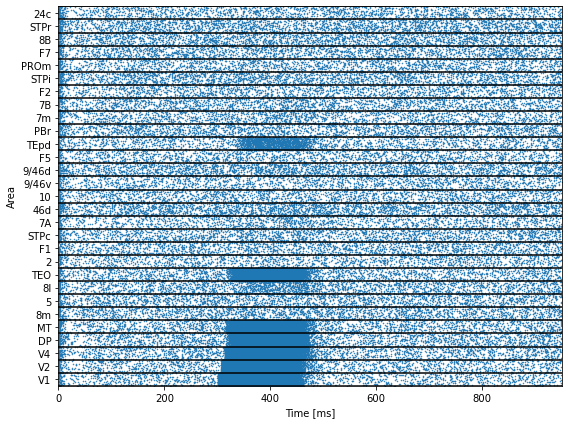

In [9]:
times, indices = np.where(runner.mon['E.spike'])
times = runner.mon.ts[times]
raster_plot(times, indices, length)